# **Machine Learning on Big Data (CN7030) CRWK 23-24 Term B [60% weighting]**
# **Group ID: [Your Group ID]**
1.   Student 1: Philip Acquaye-Mensah 2640756
2.   Student 2: Mohamed Jareer MOHAMED  ZEENAM 2596353

---

If you want to add comments on your group work, please write it here for us:


# **Initiate and Configure Spark**

In [86]:
from pyspark.sql import SparkSession
from pyspark.ml.feature import StringIndexer, VectorAssembler, StandardScaler, MinMaxScaler, RobustScaler, Imputer
from pyspark.ml.classification import LogisticRegression, NaiveBayes
from pyspark.ml.evaluation import MulticlassClassificationEvaluator
from pyspark.ml.regression import LinearRegression


# Initialize SparkSession
spark = SparkSession.builder \
                    .appName("Group 13 CRWK") \
                    .master("local[*]") \
                    .config("spark.executor.memory", "4g") \
                    .config("spark.driver.memory", "2g") \
                    .config("spark.executor.cores", "2") \
                    .config("spark.sql.inMemoryColumnarStorage.compressed", "true") \
                    .getOrCreate()



---
# **Task 1 - Data Loading and Preprocessing (15 marks)**
---

In [87]:
#Identify the student who made a contribution and mention their name in the appropriate section of the code.

## Philip Acquaye-Mensah

# Load the compressed file as a text file
df = spark.read.csv("CourseWork_Dataset_Machine_Learning.csv", header = True)
# Display the DataFrame
df.show(20, truncate= False)

# more info
print(df.count(), df.rdd.getNumPartitions())

+--------+--------+-------------------+-------------+------------+------------+---------------+---------------+---------------+---------------+----------------+---------------+---------------+---------------+----------------+---------------+-----------+-----------+-------------+------------+------------+------------+-----------+------------+-----------+-----------+-----------+-----------+------------+-----------+-----------+-----------+-------------+-------------+-------------+-------------+--------------+--------------+-----------+-----------+-----------+-----------+------------+-----------+-----------+------------+------------+------------+------------+------------+------------+--------------+------------+-------------+------------+----------------+----------------+--------------+--------------+----------------+--------------+--------------+----------------+----------------+----------------+----------------+----------------+-----------------+-----------------+-----------------+------

In [88]:
from pyspark.sql.functions import col
from pyspark.sql.types import FloatType

# Exclude 'Label' column from casting
columns_to_cast = [column for column in df.columns if column != 'Label']

for column in columns_to_cast:
    new_column = column.replace(' ', '_').replace('/', '_per_')
    df = df.withColumnRenamed(column, new_column).withColumn(new_column, col(new_column).cast(FloatType()))

In [89]:
# Check Multi class label
# Label is the column named Label
df.select("Label").distinct().show(20)

+--------------+
|         Label|
+--------------+
|        Benign|
|FTP-BruteForce|
|SSH-Bruteforce|
+--------------+



In [90]:
from pyspark.sql.functions import when, col

# Convert "Label" into a binary classification where "Benign" is 0 and any attack is 1
df = df.withColumn("Label_binary", when(col("Label") == "Benign", 0).otherwise(1))

# Display the updated DataFrame to verify the transformation
df.select("Label", "Label_binary").distinct().show()

+--------------+------------+
|         Label|Label_binary|
+--------------+------------+
|FTP-BruteForce|           1|
|        Benign|           0|
|SSH-Bruteforce|           1|
+--------------+------------+



In [91]:
# Drop Label column because of new binary label and Timestamp column
df = df.drop("Label","Timestamp")

# Print the schema to see the data types and structure
df.printSchema()

root
 |-- Dst_Port: float (nullable = true)
 |-- Protocol: float (nullable = true)
 |-- Flow_Duration: float (nullable = true)
 |-- Tot_Fwd_Pkts: float (nullable = true)
 |-- Tot_Bwd_Pkts: float (nullable = true)
 |-- TotLen_Fwd_Pkts: float (nullable = true)
 |-- TotLen_Bwd_Pkts: float (nullable = true)
 |-- Fwd_Pkt_Len_Max: float (nullable = true)
 |-- Fwd_Pkt_Len_Min: float (nullable = true)
 |-- Fwd_Pkt_Len_Mean: float (nullable = true)
 |-- Fwd_Pkt_Len_Std: float (nullable = true)
 |-- Bwd_Pkt_Len_Max: float (nullable = true)
 |-- Bwd_Pkt_Len_Min: float (nullable = true)
 |-- Bwd_Pkt_Len_Mean: float (nullable = true)
 |-- Bwd_Pkt_Len_Std: float (nullable = true)
 |-- Flow_Byts_per_s: float (nullable = true)
 |-- Flow_Pkts_per_s: float (nullable = true)
 |-- Flow_IAT_Mean: float (nullable = true)
 |-- Flow_IAT_Std: float (nullable = true)
 |-- Flow_IAT_Max: float (nullable = true)
 |-- Flow_IAT_Min: float (nullable = true)
 |-- Fwd_IAT_Tot: float (nullable = true)
 |-- Fwd_IAT_Mean:

In [92]:
# Check for missing values in each column
from pyspark.sql.functions import isnan, when, count, col
df.select([count(when(isnan(c) | col(c).isNull(), c)).alias(c) for c in df.columns]).show()

+--------+--------+-------------+------------+------------+---------------+---------------+---------------+---------------+----------------+---------------+---------------+---------------+----------------+---------------+---------------+---------------+-------------+------------+------------+------------+-----------+------------+-----------+-----------+-----------+-----------+------------+-----------+-----------+-----------+-------------+-------------+-------------+-------------+--------------+--------------+--------------+--------------+-----------+-----------+------------+-----------+-----------+------------+------------+------------+------------+------------+------------+--------------+------------+-----------------+------------+----------------+----------------+------------------+------------------+----------------+------------------+------------------+----------------+----------------+----------------+----------------+----------------+-----------------+-----------------+----------

In [93]:
from pyspark.sql.functions import col
from pyspark.sql.types import FloatType


# Now, use the Imputer on the renamed column
imputer = Imputer(
    inputCols=["Flow_Byts_per_s"],
    outputCols=["Flow_Byts_s_imputed"]
).setStrategy("median")

df = imputer.fit(df).transform(df)

# Drop the 'Flow_Byts_per_s' column
df = df.drop('Flow_Byts_per_s')

# Print Schema again to check the changes
df.printSchema()

root
 |-- Dst_Port: float (nullable = true)
 |-- Protocol: float (nullable = true)
 |-- Flow_Duration: float (nullable = true)
 |-- Tot_Fwd_Pkts: float (nullable = true)
 |-- Tot_Bwd_Pkts: float (nullable = true)
 |-- TotLen_Fwd_Pkts: float (nullable = true)
 |-- TotLen_Bwd_Pkts: float (nullable = true)
 |-- Fwd_Pkt_Len_Max: float (nullable = true)
 |-- Fwd_Pkt_Len_Min: float (nullable = true)
 |-- Fwd_Pkt_Len_Mean: float (nullable = true)
 |-- Fwd_Pkt_Len_Std: float (nullable = true)
 |-- Bwd_Pkt_Len_Max: float (nullable = true)
 |-- Bwd_Pkt_Len_Min: float (nullable = true)
 |-- Bwd_Pkt_Len_Mean: float (nullable = true)
 |-- Bwd_Pkt_Len_Std: float (nullable = true)
 |-- Flow_Pkts_per_s: float (nullable = true)
 |-- Flow_IAT_Mean: float (nullable = true)
 |-- Flow_IAT_Std: float (nullable = true)
 |-- Flow_IAT_Max: float (nullable = true)
 |-- Flow_IAT_Min: float (nullable = true)
 |-- Fwd_IAT_Tot: float (nullable = true)
 |-- Fwd_IAT_Mean: float (nullable = true)
 |-- Fwd_IAT_Std: flo

In [94]:
df.describe("Flow_Pkts_per_s").show(10)

+-------+---------------+
|summary|Flow_Pkts_per_s|
+-------+---------------+
|  count|        1048575|
|   mean|       Infinity|
| stddev|            NaN|
|    min|   -0.001029761|
|    max|       Infinity|
+-------+---------------+



In [95]:
from pyspark.sql.functions import col, isnan

# Iterate through each column in the DataFrame
for column in df.columns:
    # Filter rows where the column contains problematic values
    problematic_rows = df.filter(
        (col(column).isNull()) |   # Check for null values
        (isnan(col(column))) |     # Check for NaN values
        (col(column) < 0)          # Check for negative values
    )
    
    # If there are any rows containing problematic values, print the column name
    if problematic_rows.count() > 0:
        print(f"Column '{column}' has {problematic_rows.count()} rows with problematic values.")

Column 'Flow_Duration' has 5 rows with problematic values.
Column 'Flow_Pkts_per_s' has 5 rows with problematic values.
Column 'Flow_IAT_Mean' has 5 rows with problematic values.
Column 'Flow_IAT_Max' has 2 rows with problematic values.
Column 'Flow_IAT_Min' has 5 rows with problematic values.
Column 'Fwd_IAT_Tot' has 5 rows with problematic values.
Column 'Fwd_IAT_Mean' has 5 rows with problematic values.
Column 'Fwd_IAT_Max' has 2 rows with problematic values.
Column 'Fwd_IAT_Min' has 5 rows with problematic values.
Column 'Init_Fwd_Win_Byts' has 219266 rows with problematic values.
Column 'Init_Bwd_Win_Byts' has 347370 rows with problematic values.


In [96]:
from pyspark.sql.functions import when, col

# List of columns to replace Infinity values with NaN
columns = ["Flow_Byts_s_imputed", "Flow_Pkts_per_s"]

#! Loop through each column and replace Infinity with NaN
for col_name in columns:
    df = df.withColumn(col_name, when(col(col_name) == float('inf'), float('nan')).otherwise(col(col_name)))
    
#! Replace negative values with zero for all columns in the DataFrame
for col_name in df.columns:
    df = df.withColumn(col_name, when(df[col_name] < 0, 0).otherwise(df[col_name]))


output_cols = ["Flow_Byts_s_nan_imputed", "Flow_Pkts_per_s_nan_imputed"]


#! impute nan values with mean
imputer = Imputer(
    inputCols=columns,
    outputCols=output_cols
).setStrategy("median")



df = imputer.fit(df).transform(df)

df.describe("Flow_Byts_s_nan_imputed").show()

+-------+-----------------------+
|summary|Flow_Byts_s_nan_imputed|
+-------+-----------------------+
|  count|                1048575|
|   mean|     193096.85716243155|
| stddev|      3096074.866298894|
|    min|                    0.0|
|    max|           4.45249984E8|
+-------+-----------------------+



In [97]:
df = df.drop('Flow_Byts_s_imputed', 'Flow_Pkts_per_s')

df.show(10, truncate=False)

+--------+--------+-------------+------------+------------+---------------+---------------+---------------+---------------+----------------+---------------+---------------+---------------+----------------+---------------+-------------+------------+------------+------------+------------+------------+-----------+-----------+-----------+-----------+------------+-----------+-----------+-----------+-------------+-------------+-------------+-------------+--------------+--------------+--------------+--------------+-----------+-----------+------------+-----------+-----------+------------+------------+------------+------------+------------+------------+--------------+------------+-----------------+------------+----------------+----------------+------------------+------------------+----------------+------------------+------------------+----------------+----------------+----------------+----------------+----------------+-----------------+-----------------+-----------------+----------------+------

In [98]:
# Check for missing values again
df.select([count(when(isnan(c) | col(c).isNull(), c)).alias(c) for c in df.columns]).show()

+--------+--------+-------------+------------+------------+---------------+---------------+---------------+---------------+----------------+---------------+---------------+---------------+----------------+---------------+-------------+------------+------------+------------+-----------+------------+-----------+-----------+-----------+-----------+------------+-----------+-----------+-----------+-------------+-------------+-------------+-------------+--------------+--------------+--------------+--------------+-----------+-----------+------------+-----------+-----------+------------+------------+------------+------------+------------+------------+--------------+------------+-----------------+------------+----------------+----------------+------------------+------------------+----------------+------------------+------------------+----------------+----------------+----------------+----------------+----------------+-----------------+-----------------+-----------------+----------------+-------

In [99]:
# Summary statistics
df.describe().show()

+-------+-----------------+------------------+--------------------+------------------+------------------+------------------+-----------------+------------------+------------------+------------------+-----------------+-----------------+------------------+-----------------+------------------+------------------+-------------------+--------------------+------------------+--------------------+-----------------+-------------------+--------------------+-----------------+-------------------+------------------+-----------------+------------------+------------------+-------------------+-------------+-------------+-------------+------------------+-----------------+------------------+------------------+------------------+------------------+------------------+------------------+------------------+--------------------+-------------------+--------------------+-------------------+-------------------+-------------------+--------------+--------------------+------------------+-----------------+----------

In [100]:
# Now proceed with your VectorAssembler and the rest of the pipeline
from pyspark.ml.feature import VectorAssembler

# Assuming 'feature_columns' is updated to exclude 'Flow_Byts_s' and includes 'Flow_Byts_s_imputed'
feature_columns = [column for column in df.columns if column not in ['Label_binary']]  # Assuming you've already removed 'Flow_Byts_s'

vectorAssembler = VectorAssembler(inputCols=feature_columns, outputCol="features")

data = vectorAssembler.transform(df)

data = data.select('features', 'Label_binary')
data.show(5)


+--------------------+------------+
|            features|Label_binary|
+--------------------+------------+
|(78,[2,3,15,16,17...|           0|
|(78,[2,3,15,16,17...|           0|
|(78,[2,3,15,16,17...|           0|
|(78,[0,1,2,3,4,5,...|           0|
|(78,[0,1,2,3,4,5,...|           0|
+--------------------+------------+
only showing top 5 rows



In [101]:
# Check again for any null or NaN values that might have been introduced
df.select([count(when(isnan(c) | col(c).isNull(), c)).alias(c) for c in df.columns]).show()

+--------+--------+-------------+------------+------------+---------------+---------------+---------------+---------------+----------------+---------------+---------------+---------------+----------------+---------------+-------------+------------+------------+------------+-----------+------------+-----------+-----------+-----------+-----------+------------+-----------+-----------+-----------+-------------+-------------+-------------+-------------+--------------+--------------+--------------+--------------+-----------+-----------+------------+-----------+-----------+------------+------------+------------+------------+------------+------------+--------------+------------+-----------------+------------+----------------+----------------+------------------+------------------+----------------+------------------+------------------+----------------+----------------+----------------+----------------+----------------+-----------------+-----------------+-----------------+----------------+-------

In [102]:
# Sparse Vectors
data.show(10, truncate = False)

+-------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+------------+
|features                                                                                                                                                                                                                                                                                                                          

In [103]:
# Extract the values from Sparse Vectors to the list format
data_select = data.select('features').limit(2).collect()
for val in data_select:
    dense_vector = val[0].toArray()
    print(dense_vector)

[0.00000000e+00 0.00000000e+00 1.12641720e+08 3.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 5.63208600e+07
 1.39300034e+02 5.63209600e+07 5.63207600e+07 1.12641720e+08
 5.63208600e+07 1.39300034e+02 5.63209600e+07 5.63207600e+07
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 2.66331155e-02
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 3.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.000000

### StandardScaler

In [104]:
# Normalizing feature vectors
scaler = StandardScaler(inputCol="features", outputCol="scaledFeatures", withStd=True, withMean=False)
scaler_model = scaler.fit(data)
data = scaler_model.transform(data)

data = data.select("scaledFeatures", "Label_binary")
data.show(3, truncate = False)

+----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+------------+
|scaledFeatures                                                                                                                                                                                                                                                                                                                                                                                                              |Label_binary|
+-----------------------------------------------------------------------------------------------------------------------------------------------

In [105]:
# Split the data into training and testing sets
train_data, test_data = data.randomSplit([0.7, 0.3], seed = 42)

train_data.printSchema()

root
 |-- scaledFeatures: vector (nullable = true)
 |-- Label_binary: integer (nullable = false)



In [106]:
train_data.show(2, truncate = False)

+-------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+------------+
|scaledFeatures                                                                                                                                                  

In [107]:
#! Double check for any Negative, Infinity or NaN values

# Iterate through each column in the DataFrame
for column in df.columns:
    # Filter rows where the column contains problematic values
    problematic_rows = df.filter(
        (col(column).isNull()) |   # Check for null values
        (isnan(col(column))) |     # Check for NaN values
        (col(column) < 0)          # Check for negative values
    )
    
    # If there are any rows containing problematic values, print the column name
    if problematic_rows.count() > 0:
        print(f"Column '{column}' has {problematic_rows.count()} rows with problematic values.")

---
# **Task 2 - Model Selection and Implementation (25 marks)**
---


In [108]:
##1st student name: Philip Acquaye-Mensah
# add the code here


#### Apply Naive Bayes model

In [109]:
# 2nd student name: Mohamed Jareer Mohamed Zeenam

from pyspark.ml.classification import NaiveBayes

# Initialize Naive Bayes model
nb = NaiveBayes(featuresCol='scaledFeatures', labelCol='Label_binary', smoothing=0.5)  

# Fit the model to the training data
nb_model = nb.fit(train_data)

# Make predictions on the test data
nb_predictions = nb_model.transform(test_data)

In [110]:
# 2nd student name: Mohamed Jareer Mohamed Zeenam

nb_predictions.select('Label_binary', 'prediction').distinct().show()

+------------+----------+
|Label_binary|prediction|
+------------+----------+
|           0|       0.0|
|           1|       1.0|
|           1|       0.0|
|           0|       1.0|
+------------+----------+



---
# **Task 3 - Model Parameter Tuning (20 marks)**
---


In [111]:
# 2nd student name: Mohamed Jareer Mohamed Zeenam

from pyspark.ml.evaluation import BinaryClassificationEvaluator

# Define the evaluator for binary classification
evaluator = BinaryClassificationEvaluator(rawPredictionCol='prediction', labelCol='Label_binary', metricName='areaUnderROC')

In [112]:
##1st student name: Philip Acquaye-Mensah
# add the code here


##### Grid Search results

In [113]:
# 2nd student name: Mohamed Jareer Mohamed Zeenam

from pyspark.ml.tuning import ParamGridBuilder, CrossValidator

# Initialize Naive Bayes model
nb = NaiveBayes(featuresCol='scaledFeatures', labelCol='Label_binary')

# Define a grid of hyperparameters to search over
param_grid = ParamGridBuilder() \
              .addGrid(nb.smoothing, [0.1, 0.15, 0.2, 0.27, 0.3, 0.33, 0.4, 0.48, 0.5, 0.6, 0.7, 0.72, 0.76, 0.8, 0.9, 1]) \
              .build()

# Define cross-validation
crossval = CrossValidator(estimator=nb,
                           estimatorParamMaps=param_grid,
                           evaluator=evaluator,
                           numFolds=5)

# Fit the models and select the best one using cross-validation
cv_model = crossval.fit(train_data)

# Get the best model from cross-validation
best_nb_model = cv_model.bestModel

# Make predictions on the test data using the best model
nb_predictions = best_nb_model.transform(test_data)

# Evaluate the best model
auc = evaluator.evaluate(nb_predictions)

# Print the best hyperparameters and the evaluation metric
print("Best smoothing parameter:", best_nb_model.getOrDefault("smoothing"))
print("Area under ROC (AUC):", round(auc, 2)*100, "%")


Best smoothing parameter: 0.1
Area under ROC (AUC): 94.0 %


##### Random Search results

In [114]:
# 2nd student name: Mohamed Jareer Mohamed Zeenam

import random

# Perform random search manually
best_auc_roc = 0.0
best_params = None

for smoothing in random.sample([0.1, 0.15, 0.2, 0.27, 0.3, 0.33, 0.4, 0.48, 0.5, 0.6, 0.7, 0.72, 0.76, 0.8, 0.9, 1], 5):
    nb = NaiveBayes(featuresCol='scaledFeatures', labelCol='Label_binary', smoothing=smoothing)
    model = nb.fit(train_data)

    # Make predictions
    predictions_rand_search = model.transform(test_data)

    # Evaluate
    accuracy_rand_search = evaluator.evaluate(predictions_rand_search)

    # Check if the current model is the best so far
    if accuracy_rand_search > best_auc_roc:
        best_auc_roc = accuracy_rand_search
        best_params = smoothing


# Print the results
print("Best smoothing value: ", best_params)
print("Area under ROC curve:", round(best_auc_roc, 5) * 100)
print("Accuracy:", round(accuracy_rand_search, 5) * 100)



Best smoothing value:  0.3
Area under ROC curve: 94.33
Accuracy: 94.326


---
# **Task 4 - Model Evaluation and Accuracy Calculation (20 marks)**
---

In [115]:
##1st student name: Philip Acquaye-Mensah
# add the code here


In [116]:
# 2nd student name: Mohamed Jareer Mohamed Zeenam

import numpy as np
from sklearn.metrics import accuracy_score, precision_score, recall_score, roc_auc_score, f1_score

# Make predicitons
predictionAndTarget = nb_model.transform(test_data).select("Label_binary", "prediction")

predictionAndTargetNumpy = np.array((predictionAndTarget.collect()))

acc = accuracy_score(predictionAndTargetNumpy[:,0], predictionAndTargetNumpy[:,1])
f1 = f1_score(predictionAndTargetNumpy[:,0], predictionAndTargetNumpy[:,1])
precision = precision_score(predictionAndTargetNumpy[:,0], predictionAndTargetNumpy[:,1])
recall = recall_score(predictionAndTargetNumpy[:,0], predictionAndTargetNumpy[:,1])
auc = roc_auc_score(predictionAndTargetNumpy[:,0], predictionAndTargetNumpy[:,1])

# print the evaluation metrics
print("Accuracy:", round(acc, 5) * 100)
print("f1_score:", round(f1, 5) * 100)
print("precision:", round(precision, 5) * 100)
print("recall:", round(recall, 5) * 100)
print("AUC:", round(auc, 5) * 100)

Accuracy: 92.783
f1_score: 90.972
precision: 83.441
recall: 99.996
AUC: 94.328


#### Confusion Matrix

In [117]:
# 2nd student name: Mohamed Jareer Mohamed Zeenam

cm = nb_predictions.groupBy('Label_binary', 'prediction').count()
cm.show(cm.count(), truncate=False)

+------------+----------+------+
|Label_binary|prediction|count |
+------------+----------+------+
|0           |0.0       |177116|
|1           |1.0       |114141|
|1           |0.0       |4     |
|0           |1.0       |22636 |
+------------+----------+------+



In [118]:
# 2nd student name: Mohamed Jareer Mohamed Zeenam

#  Check the Missclassification rate
confusion_matrix = cm.groupBy('Label_binary').pivot('prediction').sum('count').na.fill(0)
confusion_matrix.show()

+------------+------+------+
|Label_binary|   0.0|   1.0|
+------------+------+------+
|           1|     4|114141|
|           0|177116| 22636|
+------------+------+------+



---
# **Task 5 - Results Visualization or Printing (5 marks)**
---

In [119]:
##1st student name: Philip Acquaye-Mensah
# add the code here


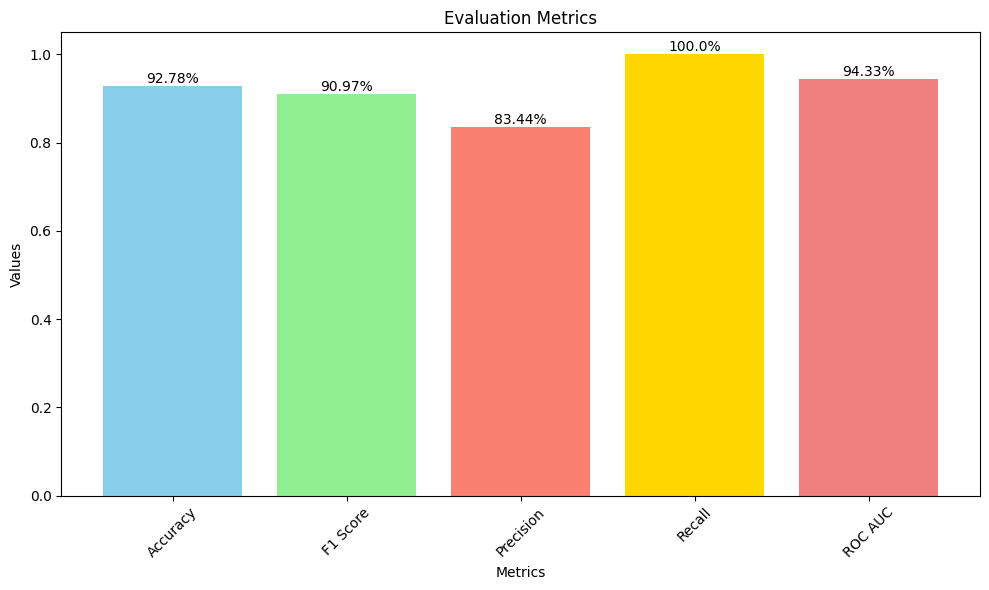

In [120]:
# 2nd student name: Mohamed Jareer Mohamed Zeenam

import matplotlib.pyplot as plt

# Define evaluation metrics and values
metrics = ['Accuracy', 'F1 Score', 'Precision', 'Recall', 'ROC AUC']
values = [acc, f1, precision, recall, auc]

# Define colors for the bars
colors = ['skyblue', 'lightgreen', 'salmon', 'gold', 'lightcoral']

# Create a bar plot with custom styling
plt.figure(figsize=(10, 6))
bars = plt.bar(metrics, values, color=colors)

# Add labels and title
plt.title('Evaluation Metrics')
plt.xlabel('Metrics')
plt.ylabel('Values')

# Add text labels on top of the bars
for bar, value in zip(bars, values):
    plt.text(bar.get_x() + bar.get_width() / 2, bar.get_height(),  f'{round(value * 100, 2)}%',
             ha='center', va='bottom')

# Show plot
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


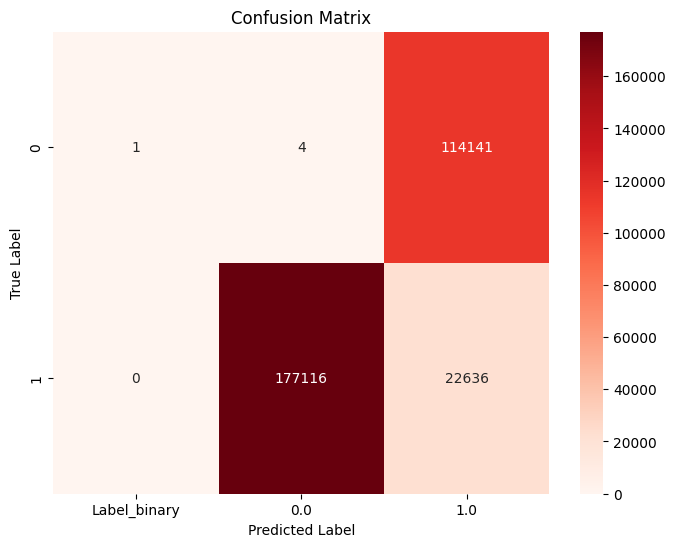

In [121]:
# 2nd student name: Mohamed Jareer Mohamed Zeenam

import seaborn as sns

# Convert confusion matrix to pandas DataFrame
confusion_matrix_pd = confusion_matrix.toPandas()

# Plotting
plt.figure(figsize=(8, 6))
sns.heatmap(confusion_matrix_pd, annot=True, cmap='Reds', fmt='g')
plt.title('Confusion Matrix')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()


---
# **Task 6 - LSEP Considerations (5 marks)**
---

# Student 1: **Type the chosen issue**

add contribution here ...

# Student 2: **Type the chosen issue**

add contribution here ...

---

# **Task 7 - Convert ipynb to HTML for Turnitin submission [5 marks]**

---



In [ ]:
# install nbconvert (if facing the conversion error)
!pip3 install nbconvert

In [ ]:
# convert ipynb to html and submit this HTML file
!jupyter nbconvert --to html Your_Group_ID_CRWK_CN7030.ipynb